# Pytorch Workflow

In [246]:
what_were_covering = {
    1: "Data (prepare and load)",
    2: "Building model",
    3: "Fitting the model to the data",
    4: "Make Preds and Evalauting the model",
    5: "Save and Load model",
    6: "Putting it all together"
}

In [247]:
import torch
from torch import nn # nn contains all of pytorch building blocks for neural networks
import matplotlib.pyplot as plt

In [248]:
torch.__version__

'2.6.0+cu118'

In [249]:
weight = 0.7
bias = 0.3

In [250]:
start = 0
end = 1
step = 0.02

In [251]:
X = torch.arange(start, end, step).unsqueeze(dim = 1)

In [252]:
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [253]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

### Splitting data and test sets

In [254]:
train_split = int(0.8 * len(X))
train_split

40

In [255]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [256]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

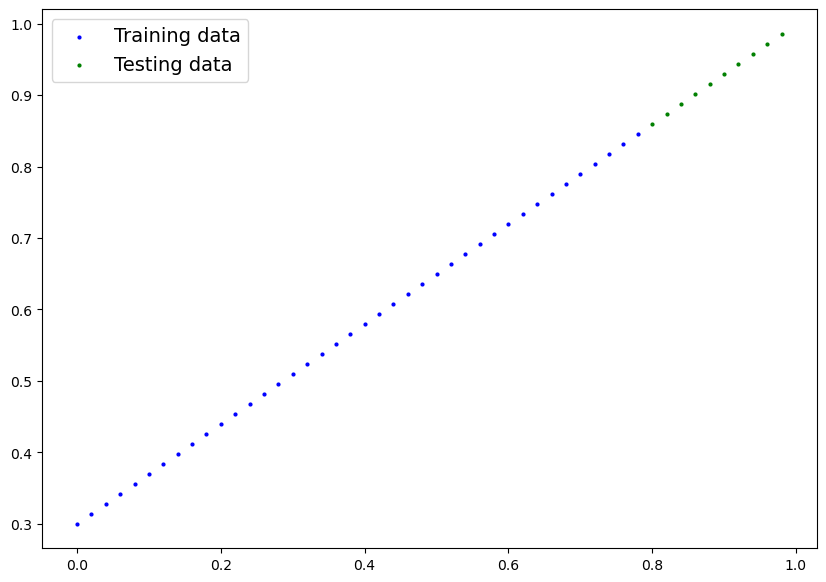

In [257]:
plot_predictions()

# Building a model

In [258]:
# Create linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))
    # Foward method tp define compution in model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- x is input data
        return self.weights * x + self.bias 
        

### Pytorch model essentials:

* `torch.nn`: Contains all of the building blocks for neural networks
* `torch.nn.Parameter`: What paramter should our model try and learn, often a pytorch layer from torch.nn will set these for us.
* `torch.nn.Module`: Base Class for all neural network models
* `torch.optim`: Optimizers lives here, for hleping with gradient descent.
* `def forward():` All nn.Module subclasses require you to overwrite foward(), this method defines what happens in the forward computation.

# For getting data ready:

* `torchvision.transforms`
* `torch.utils.data.Dataset`
* `torch.utils.data.DataLoader`

# For Building Models:

* `torch.nn`
* `torch.nn.Module`
* `torchvision.models`
* `torch.optim`
  
# For evaluating 

* `torchmetrics`

# Improve through expermintation:

* `torch.utils.tensorboard`

### Checking the contents of the pytorch model

Now we've created a model let's see what's inside

So we can check what's inside using `.paramaters()`.

In [259]:
# Create random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass)

model_0 = LinearRegressionModel()
# CHeck params
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [260]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`


To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass the data its going to run through the `forward()` method.

In [261]:
# Make preds

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [262]:
mse = torch.mean((y_test - y_preds) ** 2)
mse

tensor(0.2450)

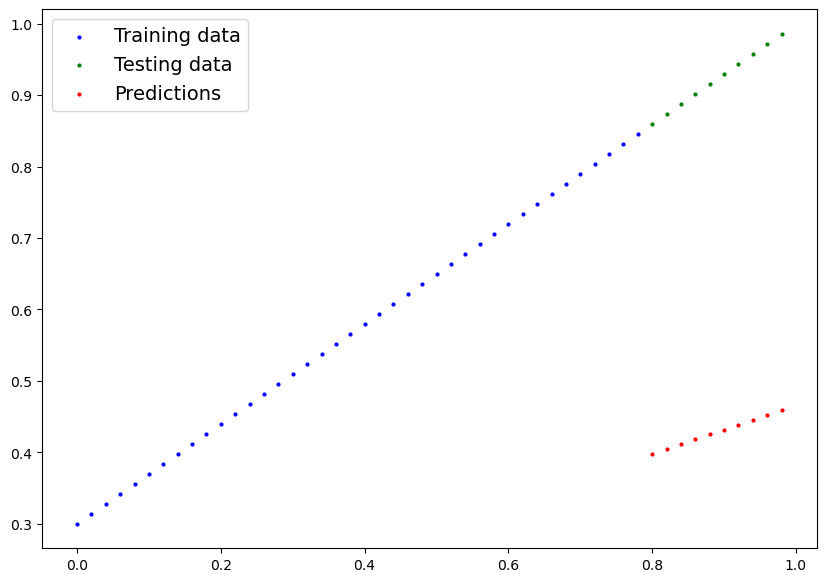

In [263]:
plot_predictions(predictions=y_preds)

### Things we need to train model:

* *Loss Function*: A function to measure how wrong your model's prediction are to the idea outputs.
* *Optimizier*: Takes into account the loss of the model and adjusts the model's parameters.

Specifically for pytorch we need a:

* Training Loop
* Testing Loop

For optimizer we need to pass **parameters** of model

In [264]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)

In [265]:
loss_fn

L1Loss()

## Building a Training Loop and Testing Loop

A couple of things we need in a training loop:

0. Loop through the data
1. Forward Propogation (this involves data moving through our model's function)
2. Calculate Loss (Compare foward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss Backward - Move backwards through network to calc gradients of each of the parameters of our model with respect to the loss.
5. Optimizer step - Use optimizer to adjust parameters and try to improve loss

In [266]:
torch.manual_seed(42)
# An epoch is one loop through data
epochs = 200

### Training
# Step 0: Loop through data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in Pytorch sets all params that requires grad with requires gradient 
    # Forward pass
    y_pred = model_0(X_train)
    # Calculate Loss
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Perform backpropogation on the loss with respect to the paramters of the model
    loss.backward()
    # 5. Step the optimizer: Perform gradient descent
    optimizer.step() # Optimizer will accumlate through the loop, so we need to reset it everytime in step 3
    
    model_0.eval() # Turns off different settings in the model not needed for evaluation/testing

    ### Testing code

    with torch.inference_mode(): # <- This turns off gradient tracking and a couple more things
        # 1. Forward Pass
        test_preds = model_0(X_test)
        # 2. Calculate Loss
        test_loss = loss_fn(test_preds, y_test)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss} | Test loss: {test_loss}")
    

Epoch 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Epoch 140 | Loss

In [267]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [268]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

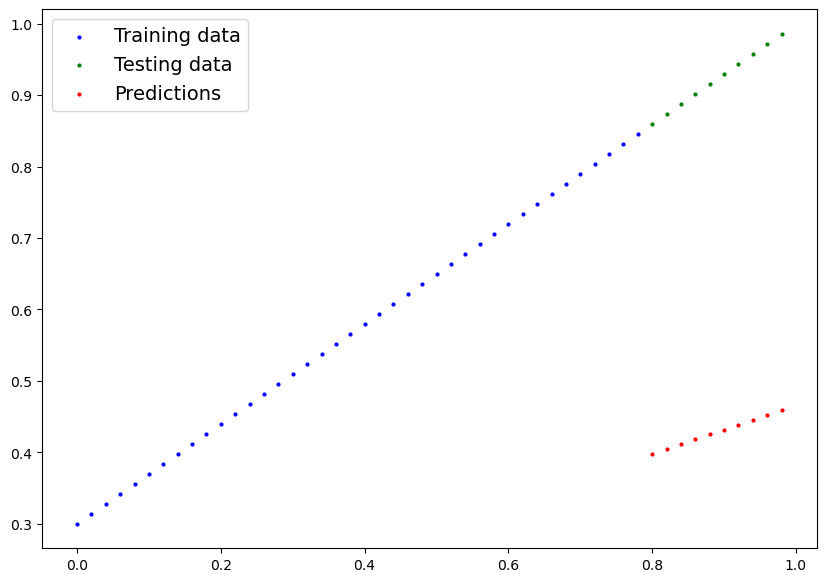

In [269]:
plot_predictions(predictions=y_preds)

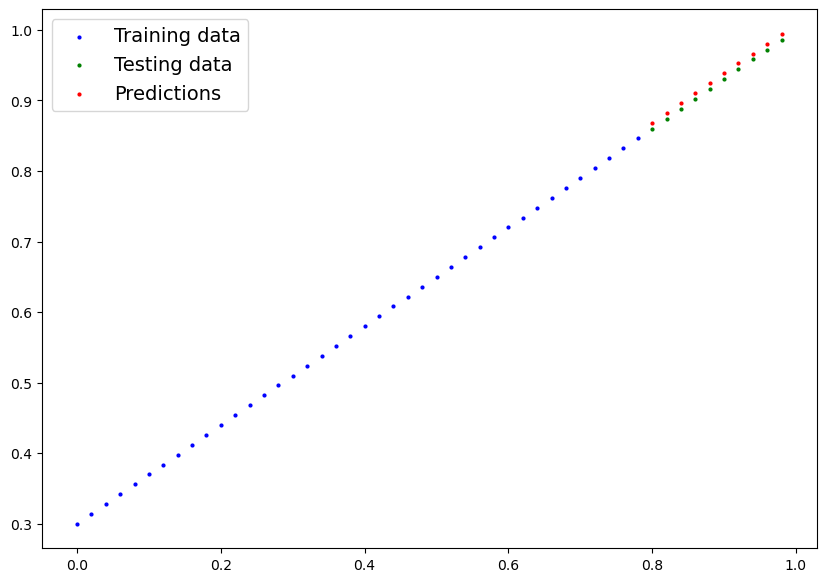

In [270]:
plot_predictions(predictions=y_preds_new)

### Saving a model in Pytorch:

There are three ways to do this:

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: Load a model's saved dictionary

In [271]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

### 6. Puttiing it all back together

In [272]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## Create device agnostic code:

If GPU exists then use otherwise CPU

In [273]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Data: 

Create data using LinearRegression Data using `y = mx + c`

In [404]:
weight = 0.7
bias = 0.3

# Create range values

start = 0
end = 1
step = 0.02

# Create X and y

X = torch.arange(start, end, step).unsqueeze(dim= 1)
y = weight * X + bias

X[:2], y[:2]

(tensor([[0.0000],
         [0.0200]]),
 tensor([[0.3000],
         [0.3140]]))

In [433]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  train_data = train_data.cpu().numpy() 
  train_labels = train_labels.cpu().numpy()
  test_data = test_data.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
    

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [434]:
# Split the data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test)

(40, 10)

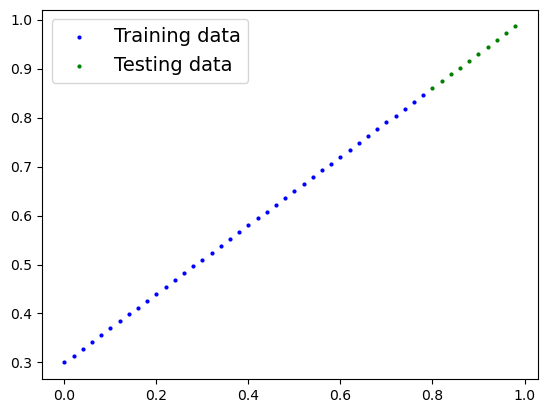

In [435]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

In [436]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        ## Use nn.Linear() for creating the model parameters / also called linear transfom, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features= 1, out_features=1)
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.linear_layer(x)
        

In [437]:
torch.manual_seed(42)
model = LinearRegression()

In [438]:
model.to(device)

LinearRegression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [439]:
next(model.parameters()).device

device(type='cuda', index=0)

In [440]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [441]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr = 0.01)
epochs = 200

In [442]:
torch.manual_seed(42)
# Put data on GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    model.train()
    
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)
# Print 
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.3084445595741272 | Test Loss: 0.3276861608028412
Epoch: 10 | Loss: 0.19325116276741028 | Test Loss: 0.1937667429447174
Epoch: 20 | Loss: 0.12119390070438385 | Test Loss: 0.11270599812269211
Epoch: 30 | Loss: 0.0761176124215126 | Test Loss: 0.06411734968423843
Epoch: 40 | Loss: 0.04791749641299248 | Test Loss: 0.03537705913186073
Epoch: 50 | Loss: 0.030273234471678734 | Test Loss: 0.018689408898353577
Epoch: 60 | Loss: 0.01923157274723053 | Test Loss: 0.009256726130843163
Epoch: 70 | Loss: 0.012319830246269703 | Test Loss: 0.004139689262956381
Epoch: 80 | Loss: 0.007991346530616283 | Test Loss: 0.0015478996792808175
Epoch: 90 | Loss: 0.005278761964291334 | Test Loss: 0.00039929780177772045
Epoch: 100 | Loss: 0.0035769843962043524 | Test Loss: 4.6642835513921455e-05
Epoch: 110 | Loss: 0.002507530152797699 | Test Loss: 0.00010826822835952044
Epoch: 120 | Loss: 0.0018336856737732887 | Test Loss: 0.00036361892125569284
Epoch: 130 | Loss: 0.0014073698548600078 | Test Loss:

In [443]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5933]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3487], device='cuda:0'))])

In [444]:
weight, bias

(0.7, 0.3)

In [445]:
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
y_preds


tensor([[0.8234],
        [0.8352],
        [0.8471],
        [0.8590],
        [0.8708],
        [0.8827],
        [0.8946],
        [0.9064],
        [0.9183],
        [0.9302]], device='cuda:0')

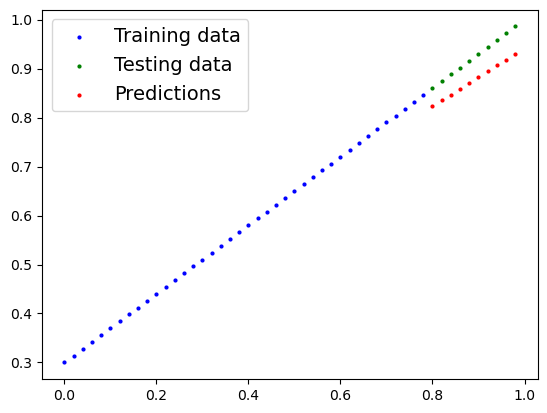

In [446]:
plot_predictions(predictions=y_preds.cpu())